# Truora

# 1 Author

**Student Name**:  Zheyun Zhao

**Student ID**:  221170559



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Methodology

Describe your methodology. Specifically, describe your training task and validation task, and how model performance is defined (i.e. accuracy, confusion matrix, etc). Any other tasks that might help you build your model should also be described here.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
from keras import models, layers, callbacks
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

In [2]:
class Config:
  def __init__(
      self,
      dataset_path: str = "../datasets/",
      story_path: str = "../datasets/CBU0521DD_stories/",
      augmented_story_path: str = "../datasets/CBU0521DD_stories/_augmented/",
      label_path: str = "../datasets/CBU0521DD_stories_attributes.csv",
      augmented_label_path: str = "../datasets/CBU0521DD_stories_attributes_augmented.csv",
      model_path: str = "../models/",
      epoch: int = 100,
      batch_size: int = 10,
  ):
    self.dataset_path = dataset_path
    self.story_path = story_path
    self.augmented_story_path = augmented_story_path
    self.label_path = label_path
    self.augmented_label_path = augmented_label_path
    self.model_path = model_path
    self.epoch = epoch
    self.batch_size = batch_size

# 4 Implemented ML prediction pipelines

Describe the ML prediction pipelines that you will explore. Clearly identify their input and output, stages and format of the intermediate data structures moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. After providing an overview, describe in more detail each one of the stages that you have included in their corresponding subsections (i.e. 4.1 Transformation stage, 4.2 Model stage, 4.3 Ensemble stage).

## 4.1 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

In [3]:
class DataTransformer:
  """
  用于完成以下功能：
  1. 读取并加载数据（包括原始数据与增强数据）
  2. 对音频数据进行特征提取（Mel-Spectrogram, MFCC, Chroma等）
  3. 保存与加载NPZ格式的数据
  """

  def __init__(self, config: Config):
    self.config = config

  # Save features and labels to a .npz file
  def save_data(features, labels, file_path):
      np.savez(file_path, features=features, labels=labels)
      print(f"Dataset saved to: {file_path}")

  # 加载数据
  def load_data_from_npz(self, file_path):
      data = np.load(file_path)
      return data['features'], data['labels']

  def load_data(
      self,
      dataset_path: str,
      labels_df: pd.DataFrame,
      augmented: bool = False
  ) -> Tuple[np.ndarray, np.ndarray]:
    """
    augmented=True时，读取增强后的数据及标签，否则读取原始数据。
    返回 features, labels
    """
    features = []
    labels = []

    if augmented:
      augmented_labels_df = pd.read_csv(self.config.augmented_label_path)
      filenames = augmented_labels_df["filename"].tolist()
    else:
      filenames = labels_df["filename"].tolist()

    for filename in tqdm(filenames, desc="Loading data", ncols=100, unit="file"):
      file_path = os.path.join(dataset_path, filename)
      audio_features = self.extract_features(file_path)

      if augmented:
        story_type = augmented_labels_df[
            augmented_labels_df["filename"] == filename
        ]["Story_type"].values[0]
      else:
        story_type = labels_df[
            labels_df["filename"] == filename
        ]["Story_type"].values[0]

      features.append(audio_features)
      labels.append(story_type)

    return np.array(features), np.array(labels)

  @staticmethod
  def extract_features(
      file_path: str,
      sr: int = 16000,
      n_mels: int = 128,
      duration: int = 240,
  ) -> np.ndarray:
    """
    提取音频特征，包括Mel-Spectrogram、MFCC、Chroma、ZCR、能量、持续时间、谱质心、滚降点等。
    最终将所有特征拼接到同一矩阵中，并做定长处理。
    """
    audio, sr = librosa.load(file_path, sr=sr)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy = np.sum(audio ** 2) / len(audio)
    duration_feature = len(audio) / sr

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr)

    features = np.vstack([
        log_mel_spectrogram,
        mfcc,
        chroma,
        zero_crossing_rate,
        spectral_centroid,
        spectral_rolloff,
        spectral_flux,
    ])

    target_length = int(sr * duration / 512)
    if features.shape[1] < target_length:
      padding = np.zeros((features.shape[0], target_length - features.shape[1]))
      features = np.concatenate([features, padding], axis=1)
    else:
      features = features[:, :target_length]

    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)
    
    features = np.concatenate([features, additional_features], axis=0)

    return features

## 4.2 Model stage

Describe the ML model(s) that you will build. Explain why you have chosen them.

In [4]:
class ModelBuilder:
  """
  负责构建与返回所需模型。
  目前包含：CNN-LSTM模型（带Attention）以及随机森林模型。
  """
  def build_cnn_lstm_model(self, input_shape: Tuple[int, int, int]) -> models.Model:
    model_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
    attention_output = layers.Attention()([x, x])  # Self-Attention

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=model_input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

  @staticmethod
  def build_rf_model(random_state: int = 42, n_estimators: int = 100) -> RandomForestClassifier:
    return RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

In [5]:
class Trainer:
  """
  负责模型的训练与可视化（如Loss、Accuracy曲线）。
  """

  def __init__(self, config: Config, model_builder: ModelBuilder):
    self.config = config
    self.model_builder = model_builder

  @staticmethod
  def show_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

  def train(
      self,
      X_train: np.ndarray,
      y_train: np.ndarray,
      X_val: np.ndarray,
      y_val: np.ndarray,
      n_models: int = 3,
      continue_training: bool = False
  ) -> List[models.Model]:
    """
    训练多个CNN-LSTM模型（集成），或加载已有模型继续训练。
    """
    model_list = []
    if continue_training:
      for i in range(n_models):
        model_path = os.path.join(self.config.model_path, f"best_model_{i + 1}.keras")
        loaded_model = models.load_model(model_path)
        model_list.append(loaded_model)
    else:
      model_list = []

    for i in range(n_models):
      if continue_training:
        model = self.model_list[i]
        print(f"Continue Train Model {i+1}")
      else:
        print(f"Train Model {i+1}")
        model = self.model_builder.build_cnn_lstm_model(
            (X_train.shape[1], X_train.shape[2], X_train.shape[3])
        )

      early_stopping = callbacks.EarlyStopping(monitor="loss", patience=100)
      model_checkpoint = callbacks.ModelCheckpoint(
          filepath=os.path.join(self.config.model_path, f"best_model_{i + 1}.keras"),
          monitor="val_accuracy",
          save_best_only=True
      )
      callbacks_list = [early_stopping, model_checkpoint]

      history = model.fit(
          X_train,
          y_train,
          epochs=self.config.epoch,
          batch_size=self.config.batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks_list
      )
      self.show_history(history)
      model_list.append(model)

    return model_list

  def train_random_forest(self, X_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
    """
    训练随机森林模型。
    """
    rf_model = self.model_builder.build_rf_model()
    # 对高维特征进行降维处理，展开为2D
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    rf_model.fit(X_train_2d, y_train)
    return rf_model

In [6]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str]):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.title("Confusion Matrix")
  plt.show()

def plot_roc_curve(y_true: np.ndarray, y_pred_prob: np.ndarray):
  fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
  plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
  plt.xlabel("1 - Specificity (FPR)")
  plt.ylabel("Sensitivity (TPR)")
  plt.title("Receiver Operating Characteristic (ROC) Curve")
  plt.legend(loc="lower right")
  plt.show()

## 4.3 Ensemble stage

Describe any ensemble approach you might have included. Explain why you have chosen them.

In [7]:
class Predictor:
  """
  用于模型预测及输出结果。包含集成预测的方法。
  """
  @staticmethod
  def ensemble_predict(
      model_list: List[models.Model],
      rf_model: RandomForestClassifier,
      X_test: np.ndarray,
      weights: Optional[List[float]] = None
  ) -> np.ndarray:
    nn_preds = np.zeros((len(model_list), X_test.shape[0]))
    for i, model in enumerate(model_list):
      nn_preds[i] = model.predict(X_test).flatten()

    print(f"NN Predictions: {nn_preds}")

    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    rf_preds = rf_model.predict_proba(X_test_2d)[:, 1]

    print(f"RF Predictions: {rf_preds}")

    if weights is None:
      weights = [1.0 / len(model_list)] * len(model_list)

    nn_pred_avg = np.average(nn_preds, axis=0, weights=weights)

    # final_pred_prob = (nn_pred_avg + rf_preds) / 2.0
    final_pred_prob = nn_pred_avg
    final_pred = (final_pred_prob > 0.5).astype(int)
    return final_pred, final_pred_prob

In [8]:
class Evaluator:
  """
  对模型进行评估，包括指标计算、混淆矩阵与ROC曲线绘制等。
  """
  @staticmethod
  def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN)  # TPR
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

  def evaluate_ensemble_model(
      self,
      model_list: List[models.Model],
      rf_model: RandomForestClassifier,
      X_test: np.ndarray,
      y_true: np.ndarray,
      labels: List[str]
  ) -> Tuple[np.ndarray, np.ndarray]:
    final_pred, final_pred_prob = Predictor.ensemble_predict(model_list, rf_model, X_test)
    print("\nEnsemble Model Evaluation:")
    self.evaluate_model(y_true, final_pred)
    plot_confusion_matrix(y_true, final_pred, labels=labels)
    plot_roc_curve(y_true, final_pred_prob)
    return final_pred, final_pred_prob

# 5 Dataset

Describe the datasets that you will create to build and evaluate your models. Your datasets need to be based on our MLEnd Deception Dataset. After describing the datasets, build them here. You can explore and visualise the datasets here as well. 

If you are building separate training and validatio datasets, do it here. Explain clearly how you are building such datasets, how you are ensuring that they serve their purpose (i.e. they are independent and consist of IID samples) and any limitations you might think of. It is always important to identify any limitations as early as possible. The scope and validity of your conclusions will depend on your ability to understand the limitations of your approach.

If you are exploring different datasets, create different subsections for each dataset and give them a name (e.g. 5.1 Dataset A, 5.2 Dataset B, 5.3 Dataset 5.3) .



# 6 Experiments and results

Carry out your experiments here. Analyse and explain your results. Unexplained results are worthless.

In [9]:
class Pipeline:
  def __init__(self, config: Config, data_transformer: DataTransformer = None, model_builder: ModelBuilder = None, trainer: Trainer = None, evaluator: Evaluator = None, predictor: Predictor = None):
    self.config = config
    self.model_list = []
    self.rf_model: RandomForestClassifier = None
    self.use_nn: bool = True
    self.use_rf: bool = True
    self.data_transformer = data_transformer
    self.model_builder = model_builder
    self.trainer = trainer
    self.evaluator = evaluator
    self.predictor = predictor

  def enable_nn(self):
    self.use_nn = True

  def disable_nn(self):
    self.use_nn = False

  def enable_rf(self):
    self.use_rf = True

  def disable_rf(self):
    self.use_rf = False

  def load_nn_models(self, model_path: List[str]):
    self.model_list = [models.load_model(path) for path in model_path]

  def pre_process(self, load_from_npz: bool = False):
    if load_from_npz:
      original_features, original_labels = self.data_transformer.load_data_from_npz(os.path.join(self.config.dataset_path, "original_data.npz"))
      augmented_features, augmented_labels = self.data_transformer.load_data_from_npz(os.path.join(self.config.dataset_path, "augmented_data.npz"))
    else:
      labels_df = pd.read_csv(self.config.label_path)
      original_features, original_labels = self.data_transformer.load_data(self.config.story_path, labels_df, augmented=False)
      augmented_features, augmented_labels = self.data_transformer.load_data(self.config.augmented_story_path, labels_df, augmented=True)
    
    # 合并原始数据和增强数据
    features = np.concatenate((original_features, augmented_features), axis=0)
    labels = np.concatenate((original_labels, augmented_labels), axis=0)

    print(f"Original dataset size: {original_features.shape[0]}, Augmented dataset size: {augmented_features.shape[0]}")
    print(f"Combined dataset size: {features.shape[0]}")

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # First split: 70% training, 30% temporary (to be split further)
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

    # Second split: 50% of the 30% temporary set to validation and test (15% each)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, y_train, X_val, y_val, X_test, y_test, label_encoder

  def nn_train(self, X_train, y_train, X_val, y_val, n_models: int = 1, continue_training: bool = False):
    self.model_list = self.trainer.train(X_train, y_train, X_val, y_val,  n_models=n_models, continue_training=continue_training)

  def rf_train(self, X_train, y_train):
    self.rf_model = self.trainer.train_random_forest(X_train, y_train)

  def evaluate(self, model_list, rf_model, label_encoder, X_test, y_test):
    labels=['Deceptive Story', 'True Story']
    # 评估集成模型
    final_pred, final_pred_prob = self.evaluator.evaluate_ensemble_model(model_list=model_list, rf_model=rf_model, X_test=X_test, y_true=y_test, labels=labels)

    # 输出预测结果与真实标签
    predicted_labels = label_encoder.inverse_transform(final_pred)
    true_labels = label_encoder.inverse_transform(y_test)
    for true, pred in zip(true_labels, predicted_labels):
        print(f"Actual: {true}, Predicted: {pred}")

  def process_audio(self, audio_path: str) -> bool:
    features = self.data_transformer.extract_features(audio_path)
    return self.predictor.ensemble_predict(self.trainer.model_list, self.trainer.rf_model, features)

In [10]:
config = Config(
    dataset_path="../datasets/",
    story_path="../datasets/CBU0521DD_stories/",
    augmented_story_path="../datasets/CBU0521DD_stories/_augmented/",
    label_path="../datasets/CBU0521DD_stories_attributes.csv",
    augmented_label_path="../datasets/CBU0521DD_stories_attributes_augmented.csv",
    model_path="../models/",
    epoch=2,
    batch_size=10,
)

data_transformer = DataTransformer(config)
model_builder = ModelBuilder()
trainer = Trainer(config, model_builder)
evaluator = Evaluator()
predictor = Predictor()

In [11]:
pipeline = Pipeline(config, data_transformer, model_builder, trainer, evaluator, predictor)

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test, label_encoder = pipeline.pre_process(load_from_npz=True)

Original dataset size: 100, Augmented dataset size: 500
Combined dataset size: 600


In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((420, 166, 7500, 1),
 (420,),
 (90, 166, 7500, 1),
 (90,),
 (90, 166, 7500, 1),
 (90,))

In [20]:
pipeline.load_nn_models(["../models/backup/1/best_model_1.keras"])

In [ ]:
pipeline.rf_train(X_train, y_train)

In [18]:
pipeline.model_list, pipeline.rf_model

([<Functional name=functional, built=True>],
 RandomForestClassifier(random_state=42))

In [ ]:
pipeline.nn_train(X_train, y_train, X_val, y_val, n_models=1, continue_training=False)

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step
NN Predictions: [[0.96151578 0.64650631 0.71569204 0.40903622 0.47562954 0.00455321
  0.5078178  0.75491863 0.8351118  0.5185169  0.95932353 0.08266664
  0.35578328 0.49829069 0.53974801 0.03866784 0.19692208 0.79926586
  0.44867313 0.8311215  0.94628614 0.07056131 0.57570815 0.99724066
  0.53960246 0.56451815 0.90448731 0.95442474 0.00911694 0.93284315
  0.99139714 0.18493241 0.04637329 0.29735151 0.02347391 0.03893143
  0.30061507 0.81904525 0.14174818 0.58375514 0.7159946  0.09571219
  0.31527737 0.90786123 0.4108339  0.06090396 0.10032266 0.21746656
  0.94692725 0.66895825 0.08499878 0.17694116 0.29967341 0.6208998
  0.12793258 0.08035327 0.87668657 0.98491919 0.26189554 0.79462814
  0.26593107 0.89764237 0.8854441  0.29582345 0.79346508 0.71239328
  0.49781412 0.21773155 0.76781297 0.27659154 0.60878438 0.00939444
  0.76883543 0.24270704 0.82438982 0.78516811 0.7273559  0.1456452
  0.66596645 0.25847089 0.01999487 0.23250824 0.90581864 0.9428

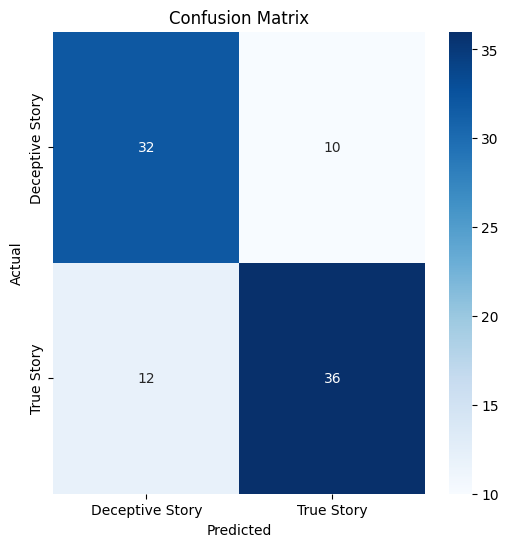

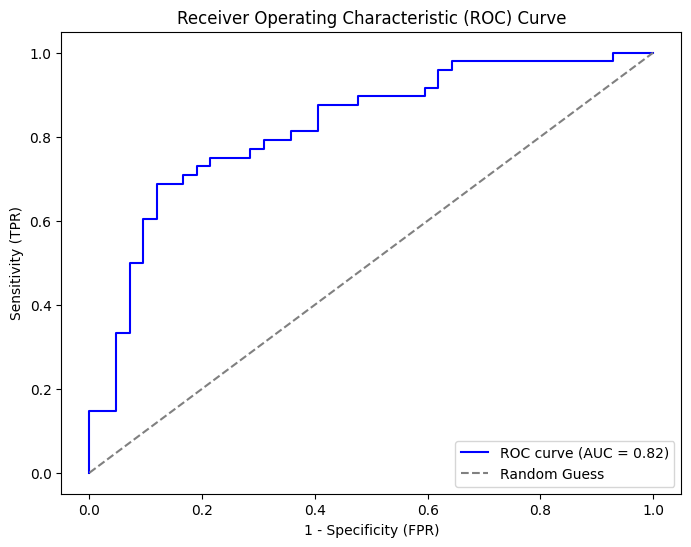

[1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0
 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1]


In [21]:
pipeline.evaluate(pipeline.model_list, pipeline.rf_model, label_encoder, X_test, y_test)

# 7 Conclusions

Your conclusions, suggestions for improvements, etc should go here.

# 8 References

Acknowledge others here (books, papers, repositories, libraries, tools) 